# scBoolSeq supp. info. : Expression profile comparison

In [1]:
import pandas as pd
import plotnine as g
import matplotlib.pyplot as plt

from scboolseq import scBoolSeq
from scboolseq.simulation import sample_from_criteria
from scboolseq.utils.customobjs import Timer, Path as path
from scboolseq.utils.diagnostics import *

import warnings
warnings.filterwarnings('ignore') # prevent plotnine from showing warnings about missing values
                                    # we know that discarded genes will not be simulated

## Parameter declaration

In [2]:
UMQ = 0.25 # unimodal margin quantile
ALPHA = 1.0 # alpha multiplier for IQR
RNG_SEED = 1234 # seed for the random number generator
THREADS = 12 # number of threads to use for parallel processing
TEXT_SIZE = 6 # the article's figures used TEXT_SIZE = 16
SAVE_FIGURES = True # should the figures be saved ?

In [3]:
if SAVE_FIGURES:
    _publish_dir = path("figures")
    if not _publish_dir.exists():
        print("creating publish dir...", end="\t")
        _publish_dir.mkdir()
        print("done")
    else:
        print("publish directory to save figures already exists.")

creating publish dir...	done


In [4]:
def violin_plot_preproc(
    unambiguous_df,
    column="Category",
    category_order=["Pooled", "Bimodal", "Unimodal", "ZeroInf", "Discarded"],
) -> pd.DataFrame:
    """This function prepares a comparison DataFrame to produce
    a violin plot for the supp. mat. of scBoolSeq main Article :
    * Concat unambiguous and category-pooled DataFrames
    * Change `column` to a categorical variable.
    * Sort the frame according to `column`.
    * Return the enhanced comparison DataFrame.
    """
    masked_df = unambiguous_df.copy(deep=True)
    # mask the column's values (Category)
    masked_df[column] = "Pooled"
    # concat the two DataFrames
    pooled_df = pd.concat([unambiguous_df, masked_df], axis="rows")
    # sort according to the specified order
    pooled_df[column] = pd.Categorical(pooled_df[column], categories=category_order)
    sorted_pooled_df = pooled_df.sort_values(column)

    return sorted_pooled_df


def save_plot_dict(
    plot_dict, location, tag="_my_plot", extension="png", width=40, height=25
):
    """save a dictionary of plotnine plots to a specified location
    note: width and height units are "cm". """
    for _name, _plot in plot_dict.items():
        _plot.save(
            location.joinpath(f"{_name}{tag}.{extension}"),
            height=height,
            width=width,
            units="cm",
            verbose=False,
        )

## Import datasets

In [5]:
!mkdir -p data_filtered_vargenes
!cd data_filtered_vargenes && test -f GSE156234_Macrophages.csv || (curl -fOL\
    https://github.com/bnediction/scBoolSeq-supplementary/releases/download/artifacts/GSE156234_Macrophages.csv.gz\
    && gunzip GSE156234_Macrophages.csv.gz)
!cd data_filtered_vargenes && test -f GSE122466_Retina.csv || (curl -fOL\
    https://github.com/bnediction/scBoolSeq-supplementary/releases/download/artifacts/GSE122466_Retina.csv.gz\
    && gunzip GSE122466_Retina.csv.gz)
!cd data_filtered_vargenes && test -f GSE81682_Hematopoiesis.csv || (curl -fOL\
    https://github.com/bnediction/scBoolSeq-supplementary/releases/download/artifacts/GSE81682_Hematopoiesis.csv.gz\
    && gunzip GSE81682_Hematopoiesis.csv.gz)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4673k  100 4673k    0     0  2522k      0  0:00:01  0:00:01 --:--:-- 5452k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2789k  100 2789k    0     0  3251k      0 --:--:-- --:--:-- --:--:-- 10.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4909k  100 4909k    0     0  4187k      0  0:00:01  0:00:01 --:--:-- 4187k


In [6]:
files = path("data_filtered_vargenes/").resolve().lglob("*csv")
frames = {
    file.name.replace(file.suffix, ""): pd.read_csv(file, index_col=0) for file in files
}
frames.keys()

dict_keys(['GSE156234_Macrophages', 'GSE122466_Retina', 'GSE81682_Hematopoiesis'])

In [7]:
for name, frame in frames.items():
    n_samples, n_genes = frame.shape
    print(f"Dataset {name} contains {n_genes} genes over {n_samples} cells")

Dataset GSE156234_Macrophages contains 818 genes over 7738 cells
Dataset GSE122466_Retina contains 688 genes over 5347 cells
Dataset GSE81682_Hematopoiesis contains 1754 genes over 1656 cells


## Create scBoolSeq instances and compute the simulation criteria

**Note**: Timing is shown in seconds.

In [7]:
%%time
scbools = {}
for name, frame in frames.items():
    with Timer(f"Training scBoolSeq instance on dataset '{name}'"):
        scbools.update(
            {
                name: scBoolSeq(data=frame, r_seed=RNG_SEED)
                .fit(unimodal_margin_quantile=UMQ, n_threads=THREADS)
                .simulation_fit(unimodal_margin_quantile=UMQ, n_threads=THREADS)
            }
        )

Training scBoolSeq instance on dataset 'GSE156234_Macrophages': 28.15893
Training scBoolSeq instance on dataset 'GSE122466_Retina': 18.42082
Training scBoolSeq instance on dataset 'GSE81682_Hematopoiesis': 19.81727
CPU times: user 23 s, sys: 301 ms, total: 23.3 s
Wall time: 1min 6s


## Sample from the learnt simulation criteria

These are not synthetic experiments reflecting activation states from Boolean Network simulations but mere samples from the parametric approximations used to model empirical gene expression count data.

In [8]:
%%time
synthetic_frames = {}
for name, _scbool in scbools.items():
    n_samples = _scbool.data.shape[0]
    with Timer(f"Generating {n_samples} samples for dataset '{name}'"):
        synthetic_frames.update(
            {
                name: sample_from_criteria(
                    _scbool.simulation_criteria,
                    n_samples=n_samples,
                    n_threads=THREADS,
                )
            }
        )

Generating 7738 samples for dataset 'GSE156234_Macrophages': 1.87306
Generating 5347 samples for dataset 'GSE122466_Retina': 2.15066
Generating 1656 samples for dataset 'GSE81682_Hematopoiesis': 9.40713
CPU times: user 182 ms, sys: 475 ms, total: 656 ms
Wall time: 13.4 s


## Expression profiles

In [9]:
comparisons = {
    name: compare_profiles(
        scbools[name].criteria,
        frames[name],
        synthetic_frames[name],
        "Original",
        "Simulated",
    )
    for name in scbools.keys()
}

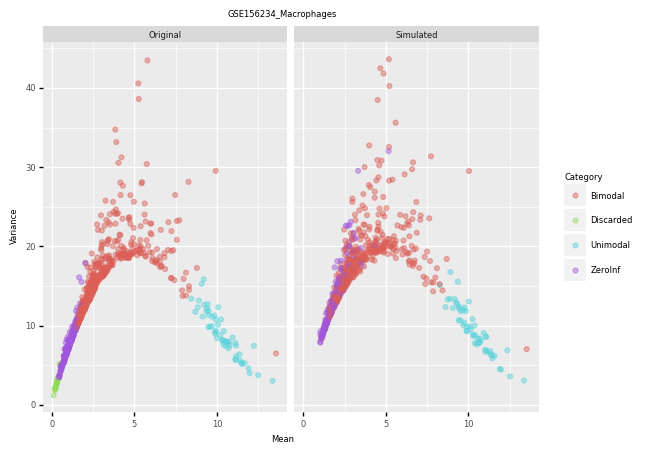

('GSE156234_Macrophages', <ggplot: (8785128025402)>)


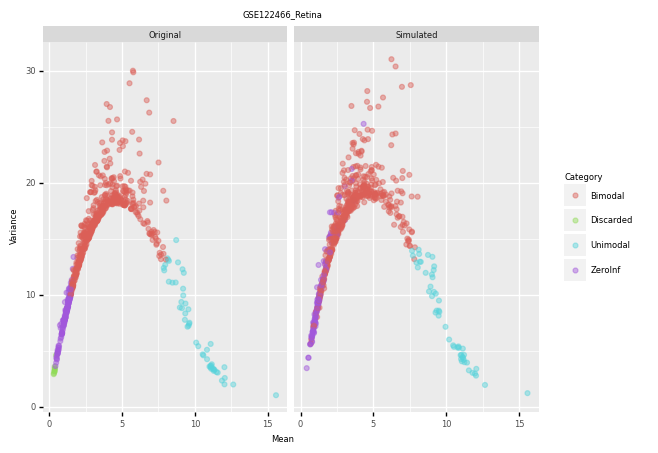

('GSE122466_Retina', <ggplot: (8785138220641)>)


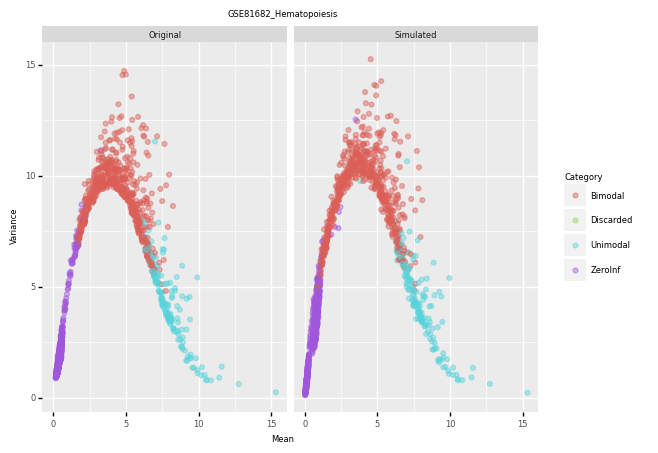

('GSE81682_Hematopoiesis', <ggplot: (8785128083104)>)


In [10]:
mean_vs_variance_plots = {
    name: (
        g.ggplot(_summary, g.aes("Mean", "Variance"))
        + g.theme(text=g.element_text(size=TEXT_SIZE))
        + g.geom_point(g.aes(color="Category", fill="Category"), alpha=0.45)
        + g.facet_wrap("~Data")
        + g.labels.ggtitle(name)
    )
    for name, _summary in comparisons.items()
}

for plot in mean_vs_variance_plots.items():
    print(plot)
    
if SAVE_FIGURES:
    save_plot_dict(mean_vs_variance_plots, _publish_dir, tag="_profile", extension="png")

## Compare the distribution of per-gene means and variances

In [11]:
enhanced_comparisons = {
    name: violin_plot_preproc(frame) for name, frame in comparisons.items()
}

### Means

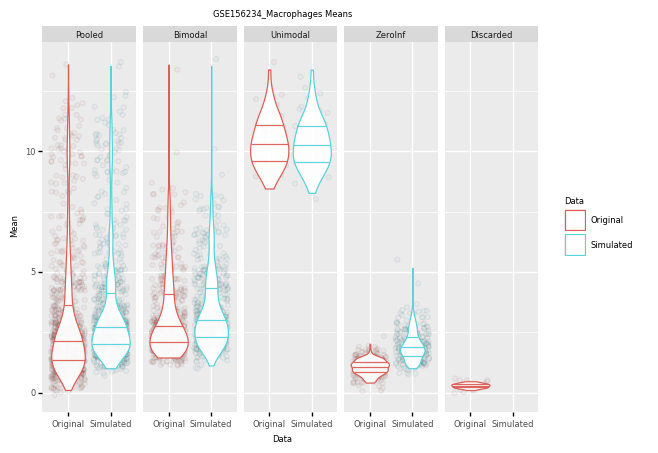

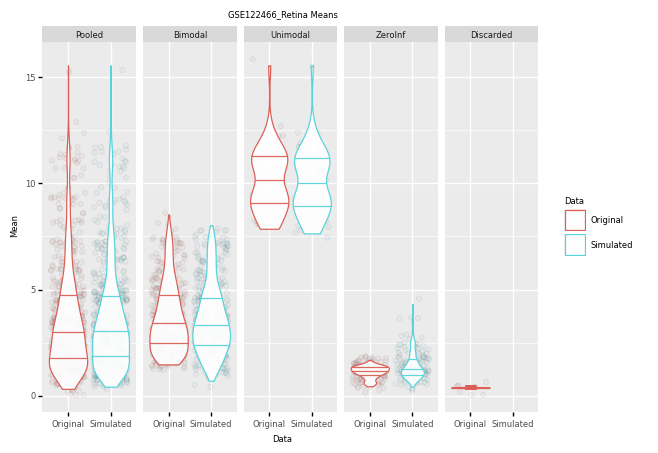

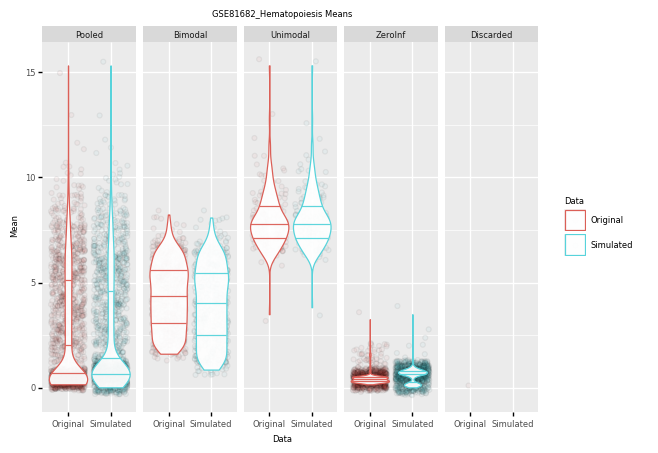

In [12]:
mean_violin_plots = {}
for name, dataset in enhanced_comparisons.items():
    mean_violin_plots.update(
        {
            name: g.ggplot(dataset, g.aes("Data", "Mean"))
            + g.theme(text=g.element_text(size=TEXT_SIZE))
            + g.geom_jitter(g.aes(fill="Data"), alpha=0.05)
            + g.geom_violin(
                g.aes(color="Data"), alpha=0.95, draw_quantiles=[0.25, 0.5, 0.75]
            )
            + g.facet_wrap("~Category", nrow=1, ncol=5)
            + g.labels.ggtitle(f"{name} Means")
        }
    )
    print(mean_violin_plots[name])
    
if SAVE_FIGURES:
    save_plot_dict(mean_violin_plots, _publish_dir, tag="_violin_means", extension="png")

## Variances

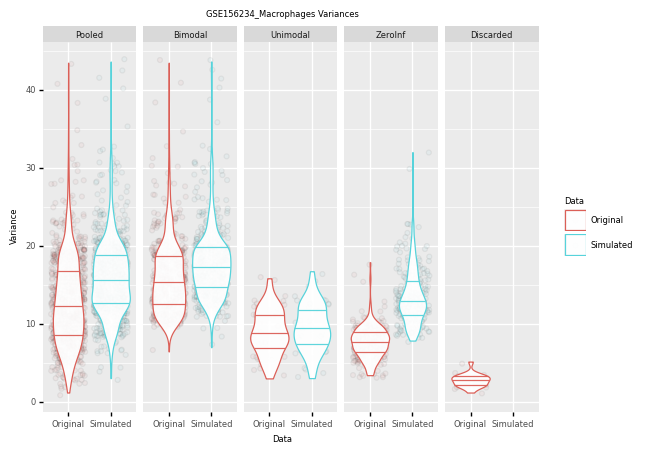

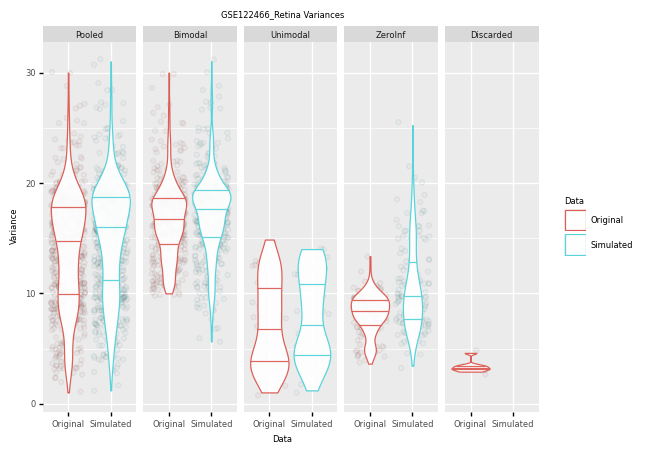

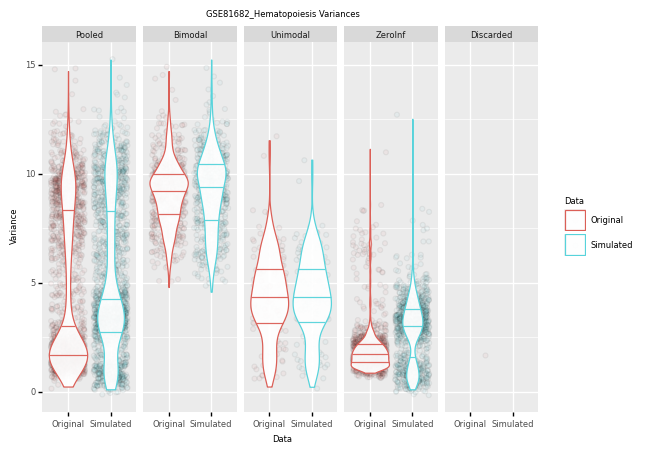

In [13]:
variance_violin_plots = {}
for name, dataset in enhanced_comparisons.items():
    variance_violin_plots.update(
        {
            name: g.ggplot(dataset, g.aes("Data", "Variance"))
            + g.theme(text=g.element_text(size=TEXT_SIZE))
            + g.geom_jitter(g.aes(fill="Data"), alpha=0.05)
            + g.geom_violin(
                g.aes(color="Data"), alpha=0.95, draw_quantiles=[0.25, 0.5, 0.75]
            )
            + g.facet_wrap("~Category", nrow=1, ncol=5)
            + g.labels.ggtitle(f"{name} Variances")
        }
    )
    print(variance_violin_plots[name])
    
if SAVE_FIGURES:
    save_plot_dict(
        variance_violin_plots, _publish_dir, tag="_violin_variances", extension="png"
    )